In [1]:
# --- Cell 0: setup, paths, tunables -----------------------------------------
import os, sys, math, json, random
from pathlib import Path
import numpy as np
from tqdm import tqdm

# 🔧 Tunables (edit these)
KITTI_ROOT   = Path(r"C:\Users\DELL\OpenPCDet\data\kitti\training")  # velodyne/, label_2/, calib/
RUN_DIR      = Path(r"D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_halo_clean")  # new, self-contained
N_FRAMES     = None         # None = use all frames with both lidar+label+calib; or set int (e.g., 3000)
SPLIT        = (0.80, 0.10, 0.10)  # (train, val, test)
SEED         = 42

# BEV geometry (set so H,W are friendly for 2x max-pool in U-Net)
X_MIN, X_MAX = 0.0, 50.0     # meters forward
Y_MIN, Y_MAX = -25.0, 25.0   # meters left/right
RES          = 0.1953125     # ~256 cells across 50 m (50/0.1953125 ≈ 256)
H = int(np.ceil((X_MAX - X_MIN) / RES))  # rows (forward)
W = int(np.ceil((Y_MAX - Y_MIN) / RES))  # cols (left/right)

# Z normalization for HAG
Z_MIN, Z_MAX = -2.5, 1.5     # clip LiDAR z to this and normalize

# Feature channels to export (order matters)
CHANNELS = ["occ", "hag", "edge"]  # choose any subset/superset from: occ, hag, edge

# Halo label (vehicle core + ring around it)
HALO_PX     = 2              # halo thickness in pixels
HALO_W_IN   = 1.0            # per-pixel weight on core
HALO_W_HALO = 0.5            # per-pixel weight on halo

# Training config
IN_CH       = len(CHANNELS)
BATCH       = 16
EPOCHS      = 50
LR          = 1e-3
BASE        = 16

# Output folders (self-contained)
FEAT_DIR = RUN_DIR / "feat"     # (C,H,W) per frame
Y_DIR    = RUN_DIR / "y"        # (H,W) vehicle core+halo 0/1
W_DIR    = RUN_DIR / "w"        # (H,W) weight map
DS_DIR   = RUN_DIR / "dataset"  # split lists & convenience copies (optional)

for d in [RUN_DIR, FEAT_DIR, Y_DIR, W_DIR, DS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"RUN_DIR={RUN_DIR}")
print(f"BEV size: (H,W)=({H},{W})  RES={RES:.4f} m/cell  X∈[{X_MIN},{X_MAX}]  Y∈[{Y_MIN},{Y_MAX}]")
print(f"Channels: {CHANNELS} (IN_CH={IN_CH})")


RUN_DIR=D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_halo_clean
BEV size: (H,W)=(256,256)  RES=0.1953 m/cell  X∈[0.0,50.0]  Y∈[-25.0,25.0]
Channels: ['occ', 'hag', 'edge'] (IN_CH=3)


In [2]:
# --- Cell 1: KITTI readers and BEV utilities --------------------------------
import re

# --- LiDAR (.bin) ---
def read_velo_bin(path: Path) -> np.ndarray:
    pts = np.fromfile(path, dtype=np.float32).reshape(-1,4)  # x,y,z,intensity in LiDAR frame
    return pts

# --- Labels (.txt) ---
VEH_TYPES = {"Car","Van","Truck","Tram","Bus"}  # collapse as 'vehicle'

def read_label_file(path: Path):
    """Return list of dicts for vehicles only (KITTI label_2 format)."""
    out = []
    if not path.exists():
        return out
    for line in path.read_text().strip().splitlines():
        f = line.strip().split()
        typ = f[0]
        if typ not in VEH_TYPES:
            continue
        # According to KITTI: h,w,l then location (x,y,z) in camera, then ry
        h, w, l = map(float, f[8:11])
        x, y, z = map(float, f[11:14])  # camera coords (bottom center)
        ry = float(f[14])
        out.append(dict(type=typ, h=h, w=w, l=l, x=x, y=y, z=z, ry=ry))
    return out

# --- Calib (.txt) ---
def read_calib(path: Path):
    """Return 4x4 T_cam_to_velo (invert of R0_rect * Tr_velo_to_cam)."""
    mats = {}
    for line in path.read_text().strip().splitlines():
        if ":" not in line: 
            continue
        key, val = line.split(":",1)
        nums = np.fromstring(val, sep=" ")
        if key.startswith("P") and nums.size==12:
            mats[key] = nums.reshape(3,4)
        elif key=="R0_rect":
            mats[key] = nums.reshape(3,3)
        elif key=="Tr_velo_to_cam":
            mats[key] = nums.reshape(3,4)
    assert "R0_rect" in mats and "Tr_velo_to_cam" in mats, "calib missing R0_rect/Tr_velo_to_cam"
    R0 = mats["R0_rect"]
    Tr = mats["Tr_velo_to_cam"]
    T_velo2cam = np.eye(4, dtype=np.float32)
    T_velo2cam[:3,:4] = R0 @ Tr
    T_cam2velo = np.linalg.inv(T_velo2cam)
    return T_cam2velo  # 4x4

# --- 3D box corners in camera coords, then transform to LiDAR ---
def box3d_corners_camera(h,w,l, ry, center_xyz_cam):
    # corners in object frame (camera convention: x-right, y-down, z-forward)
    x_c = np.array([ l/2,  l/2, -l/2, -l/2,  l/2,  l/2, -l/2, -l/2], dtype=np.float32)
    y_c = np.array([  0.,   0.,   0.,   0.,  -h,  -h,  -h,  -h ], dtype=np.float32)
    z_c = np.array([ w/2, -w/2, -w/2,  w/2,  w/2, -w/2, -w/2,  w/2], dtype=np.float32)
    cy, sy = np.cos(ry), np.sin(ry)
    R = np.array([[ cy, 0.,  sy],
                  [0.,  1., 0. ],
                  [-sy, 0.,  cy]], dtype=np.float32)
    corners = R @ np.vstack([x_c, y_c, z_c])
    corners += np.array(center_xyz_cam, dtype=np.float32).reshape(3,1)
    return corners  # (3,8) camera

def cam_to_velo(T_cam2velo, pts_cam):
    """pts_cam: (3,N) -> (3,N) LiDAR coords."""
    N = pts_cam.shape[1]
    pc = np.vstack([pts_cam, np.ones((1,N), dtype=np.float32)])
    pv = (T_cam2velo @ pc)[:3,:]
    return pv

# --- BEV mapping ---
def world_to_grid(x, y):
    """LiDAR (x forward, y left) -> (row, col) indices in [0,H),[0,W)."""
    r = ((x - X_MIN) / RES).astype(np.int32)
    c = ((y - Y_MIN) / RES).astype(np.int32)
    return r, c

def points_to_bev(pts):
    """Compute OCC (counts) and Zmax per cell. Return occ_norm, hag_norm."""
    # clip ROI
    m = (pts[:,0] >= X_MIN) & (pts[:,0] < X_MAX) & (pts[:,1] >= Y_MIN) & (pts[:,1] < Y_MAX)
    P = pts[m]
    if P.size == 0:
        return np.zeros((H,W),np.float32), np.zeros((H,W),np.float32)
    r, c = world_to_grid(P[:,0], P[:,1])
    valid = (r>=0)&(r<H)&(c>=0)&(c<W)
    r, c = r[valid], c[valid]
    z    = np.clip(P[valid,2], Z_MIN, Z_MAX)

    occ = np.zeros((H,W), np.float32)
    zmx = np.full((H,W), -1e9, np.float32)

    np.add.at(occ, (r,c), 1.0)
    np.maximum.at(zmx, (r,c), z)

    # normalize
    if occ.max() > 0:
        occ = np.clip(occ / np.percentile(occ[occ>0], 99), 0, 1)  # robust
    hag = (zmx - Z_MIN) / max(1e-6, (Z_MAX - Z_MIN))
    hag[zmx < -1e8] = 0.0
    hag = np.clip(hag, 0, 1)
    return occ, hag

# --- Simple edge from OCC ---
def occ_edge(occ):
    # 3x3 Sobel-like kernel (no scipy)
    kx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]], np.float32)
    ky = np.array([[1,2,1],[0,0,0],[-1,-2,-1]], np.float32)
    from numpy.lib.stride_tricks import sliding_window_view as swv
    pad = np.pad(occ, 1, mode="edge")
    win = swv(pad, (3,3))  # (H,W,3,3)
    gx = (win * kx).sum(axis=(2,3))
    gy = (win * ky).sum(axis=(2,3))
    g  = np.hypot(gx, gy)
    if g.max() > 0: g /= g.max()
    return g.astype(np.float32)

# --- Rasterize bottom face of 3D box (in LiDAR) on BEV grid ---
from matplotlib.path import Path as MplPath

def rasterize_polygon_xy(poly_xy):
    """poly_xy: 4x2 in LiDAR (x,y). Return (H,W) mask."""
    x = poly_xy[:,0]; y = poly_xy[:,1]
    rr, cc = world_to_grid(x, y)
    # convert polygon to pixel coords (col=x->c, row=y->r) and clip
    poly_pix = np.stack([rr, cc], axis=1).astype(np.float32)
    # bounding box in pixel space
    rmin = int(max(0, np.floor(poly_pix[:,0].min())))
    rmax = int(min(H-1, np.ceil(poly_pix[:,0].max())))
    cmin = int(max(0, np.floor(poly_pix[:,1].min())))
    cmax = int(min(W-1, np.ceil(poly_pix[:,1].max())))
    if rmin>rmax or cmin>cmax:
        return np.zeros((H,W), np.uint8)
    # point-in-polygon over the bbox
    rs = np.arange(rmin, rmax+1)
    cs = np.arange(cmin, cmax+1)
    RR, CC = np.meshgrid(rs, cs, indexing='ij')
    pts = np.stack([RR.ravel(), CC.ravel()], axis=1)
    path = MplPath(poly_pix)
    mask_local = path.contains_points(pts).reshape(RR.shape)
    mask = np.zeros((H,W), np.uint8)
    mask[rmin:rmax+1, cmin:cmax+1] = mask_local.astype(np.uint8)
    return mask

def vehicle_core_mask(labels, T_cam2velo):
    """Rasterize all vehicles into a single (H,W) 0/1 mask."""
    core = np.zeros((H,W), np.uint8)
    for obj in labels:
        corners_cam = box3d_corners_camera(obj["h"], obj["w"], obj["l"], obj["ry"],
                                           (obj["x"], obj["y"], obj["z"]))
        corners_vel = cam_to_velo(T_cam2velo, corners_cam)
        # bottom face: indices 0..3 (y=0 in camera local frame)
        bottom = corners_vel[:, [0,1,2,3]].T  # (4,3) in LiDAR
        poly_xy = bottom[:, :2]               # (4,2)
        core |= rasterize_polygon_xy(poly_xy)
    return core

# --- Halo + weights from core ---
def make_halo_and_weights(core, halo_px=HALO_PX, halo_w=HALO_W_HALO, core_w=HALO_W_IN):
    from collections import deque
    core = (core>0).astype(np.uint8)
    if halo_px <= 0:
        y = core.copy()
        w = (core*core_w).astype(np.float32)
        return y, w
    # fast ring via dilations (no SciPy): BFS distance (city-block) then approx to disk
    # We'll approximate Euclidean ring with 8-neighborhood distance.
    INF = 1<<30
    dist = np.full(core.shape, INF, np.int32)
    q = deque()
    on = np.argwhere(core>0)
    for r,c in on:
        dist[r,c]=0; q.append((r,c))
    nbr8 = [(-1,0),(1,0),(0,-1),(0,1),(-1,-1),(-1,1),(1,-1),(1,1)]
    while q:
        r,c = q.popleft()
        d = dist[r,c]
        if d >= halo_px: continue
        for dr,dc in nbr8:
            rr,cc = r+dr, c+dc
            if rr<0 or rr>=H or cc<0 or cc>=W: continue
            if dist[rr,cc] > d+1:
                dist[rr,cc] = d+1
                q.append((rr,cc))
    halo = ((dist>0) & (dist<=halo_px)).astype(np.uint8)
    y = (core | halo).astype(np.uint8)
    w = (core*core_w + halo*halo_w).astype(np.float32)
    return y, w


In [3]:
# --- Cell 2: build feat (C,H,W), y (H,W), w (H,W) from raw KITTI -------------
random.seed(SEED); np.random.seed(SEED)

VEL_DIR  = KITTI_ROOT / "velodyne"
LAB_DIR  = KITTI_ROOT / "label_2"
CAL_DIR  = KITTI_ROOT / "calib"

# Collect IDs with velodyne + label + calib present
all_ids = sorted([p.stem for p in VEL_DIR.glob("*.bin")
                  if (LAB_DIR/f"{p.stem}.txt").exists() and (CAL_DIR/f"{p.stem}.txt").exists()])
print("Frames with lidar+label+calib:", len(all_ids))
assert all_ids, "Found zero frames — check KITTI_ROOT."

if N_FRAMES is not None:
    ids = all_ids[:int(N_FRAMES)]
else:
    ids = all_ids

def build_features(occ, hag, want=CHANNELS):
    feats = []
    for ch in want:
        if ch=="occ":  feats.append(occ)
        elif ch=="hag": feats.append(hag)
        elif ch=="edge": feats.append(occ_edge(occ))
        else:
            raise ValueError(f"Unknown channel '{ch}'")
    return np.stack(feats, axis=0).astype(np.float32)

first_print = True
for fid in tqdm(ids, desc="export feat+y+w"):
    pts   = read_velo_bin(VEL_DIR / f"{fid}.bin")
    labels= read_label_file(LAB_DIR / f"{fid}.txt")
    T_c2v = read_calib(CAL_DIR / f"{fid}.txt")

    occ, hag = points_to_bev(pts)
    xC = build_features(occ, hag, CHANNELS)

    core = vehicle_core_mask(labels, T_c2v)  # 0/1 (H,W)
    y, w = make_halo_and_weights(core, HALO_PX, HALO_W_HALO, HALO_W_IN)

    np.save(FEAT_DIR / f"{fid}.npy", xC)
    np.save(Y_DIR    / f"{fid}.npy", y.astype(np.uint8))
    np.save(W_DIR    / f"{fid}.npy", w.astype(np.float32))

    if first_print:
        print("sample", fid, "| X", xC.shape, xC.min(), xC.max(),
              "| Y sum", int(y.sum()), "| W[min,max]", float(w.min()), float(w.max()))
        first_print=False

print("Cell 2 ✓ — features+labels built & saved here:", RUN_DIR)


Frames with lidar+label+calib: 7481


export feat+y+w:   0%|                                                                | 2/7481 [00:00<11:15, 11.07it/s]

sample 000000 | X (3, 256, 256) 0.0 1.0 | Y sum 0 | W[min,max] 0.0 0.0


export feat+y+w: 100%|█████████████████████████████████████████████████████████████| 7481/7481 [10:05<00:00, 12.36it/s]

Cell 2 ✓ — features+labels built & saved here: D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_halo_clean


In [4]:
# --- Cell 3: split into train/val/test ---------------------------------------
from math import floor

random.seed(SEED); np.random.seed(SEED)

ids_all = sorted([p.stem for p in FEAT_DIR.glob("*.npy")
                  if (Y_DIR/f"{p.stem}.npy").exists() and (W_DIR/f"{p.stem}.npy").exists()])
print("Exported frames available:", len(ids_all))
assert ids_all, "Nothing exported — run Cell 2 first."

random.shuffle(ids_all)
n = len(ids_all)
n_train = floor(n * SPLIT[0])
n_val   = floor(n * SPLIT[1])
n_test  = n - n_train - n_val

splits = {
    "train": ids_all[:n_train],
    "val":   ids_all[n_train:n_train+n_val],
    "test":  ids_all[n_train+n_val:]
}

for k,v in splits.items():
    (RUN_DIR / f"{k}.txt").write_text("\n".join(v))
    print(f"{k:>5} | {len(v)}")

# optional: keep only lists (we load from FEAT_DIR/Y_DIR/W_DIR at train time)
print("Cell 3 ✓ — wrote split lists under", RUN_DIR)


Exported frames available: 7481
train | 5984
  val | 748
 test | 749
Cell 3 ✓ — wrote split lists under D:\Data\essentials\Thapar\MTech\Projects\Main proj\bev_npu_outputs\run_halo_clean


In [5]:
# --- Cell 4: Dataset / DataLoaders (fixed) -----------------------------------
import torch
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class BevHaloDataset(Dataset):
    def __init__(self, id_list, feat_dir=None, y_dir=None, w_dir=None):
        # Fall back to globals defined in Cell 0 if not provided
        feat_dir = FEAT_DIR if feat_dir is None else feat_dir
        y_dir    = Y_DIR    if y_dir is None else y_dir
        w_dir    = W_DIR    if w_dir is None else w_dir

        self.ids = list(id_list)
        self.feat_dir = Path(feat_dir)
        self.y_dir    = Path(y_dir)
        self.w_dir    = Path(w_dir)

        # quick positive-pixel fraction estimate (for info)
        self.pos_frac = None
        if self.ids:
            s = 0; c = 0
            for fid in self.ids[:min(100, len(self.ids))]:
                y = np.load(self.y_dir / f"{fid}.npy").astype(np.uint8)
                s += y.sum(); c += y.size
            self.pos_frac = s / max(1, c)

    def __len__(self): 
        return len(self.ids)

    def __getitem__(self, i):
        fid = self.ids[i]
        x = np.load(self.feat_dir / f"{fid}.npy").astype(np.float32)         # (C,H,W)
        y = np.load(self.y_dir   / f"{fid}.npy").astype(np.uint8)[None, ...] # (1,H,W)
        w = np.load(self.w_dir   / f"{fid}.npy").astype(np.float32)[None, ...]# (1,H,W)
        return torch.from_numpy(x), torch.from_numpy(y), torch.from_numpy(w)

def _load_ids(txt_path: Path):
    return [s for s in Path(txt_path).read_text().splitlines() if s.strip()]

ids_train = _load_ids(RUN_DIR / "train.txt")
ids_val   = _load_ids(RUN_DIR / "val.txt")
ids_test  = _load_ids(RUN_DIR / "test.txt")

train_ds = BevHaloDataset(ids_train)
val_ds   = BevHaloDataset(ids_val)
test_ds  = BevHaloDataset(ids_test)

print(f"train: n={len(train_ds)} pos≈{(train_ds.pos_frac or 0)*100:.2f}%")
print(f"val  : n={len(val_ds)}   pos≈{(val_ds.pos_frac or 0)*100:.2f}%")
print(f"test : n={len(test_ds)}  pos≈{(test_ds.pos_frac or 0)*100:.2f}%")

train_loader = DataLoader(train_ds, batch_size=BATCH, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=BATCH, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=BATCH, shuffle=False, num_workers=0)

print("Cell 4 ✓ — loaders ready on", device)


train: n=5984 pos≈2.11%
val  : n=748   pos≈2.09%
test : n=749  pos≈1.89%
Cell 4 ✓ — loaders ready on cuda


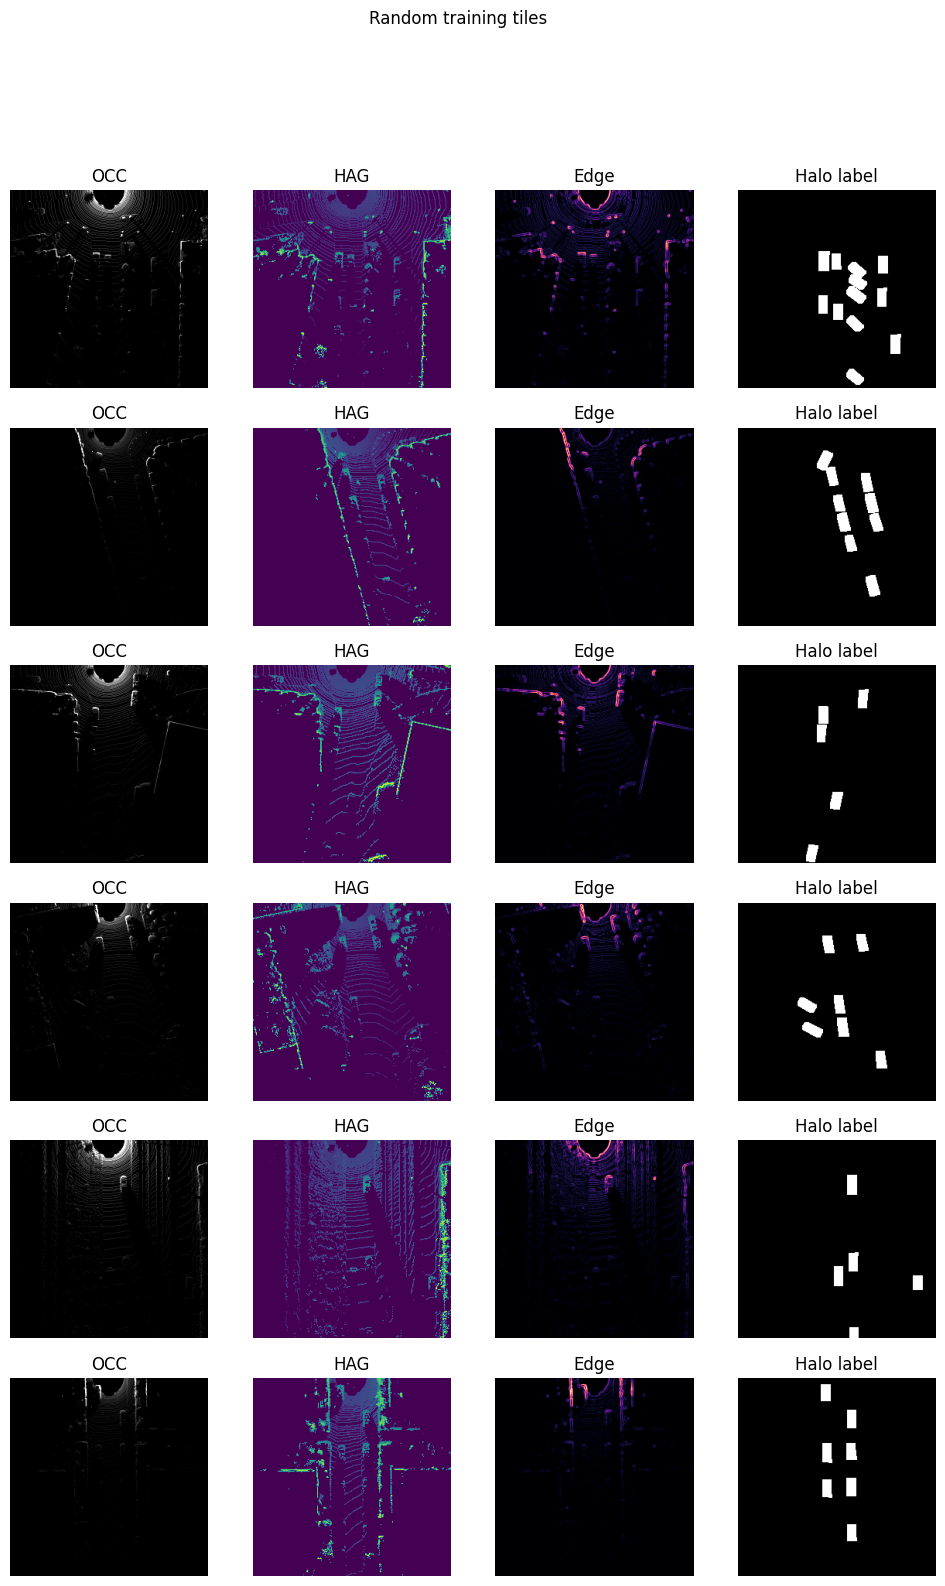

In [9]:
# Cell 4b — peek a few tiles from the training set
import numpy as np, random, matplotlib.pyplot as plt

def peek_tiles(id, k=6):
    k = min(k, len(ids))
    picks = random.sample(ids, k)
    fig, ax = plt.subplots(k, 4, figsize=(12, 3*k))
    for r, fid in enumerate(picks):
        x = np.load(FEAT_DIR/f"{fid}.npy")   # (C,H,W)
        y = np.load(Y_DIR/f"{fid}.npy")      # (H,W) 0/1
        w = np.load(W_DIR/f"{fid}.npy")      # (H,W) weights

        ax[r,0].imshow(x[0], cmap="gray", vmin=0, vmax=1);     ax[r,0].set_title("OCC")
        ax[r,1].imshow(x[1], cmap="viridis", vmin=0, vmax=1);  ax[r,1].set_title("HAG")
        ax[r,2].imshow(x[2], cmap="magma", vmin=0, vmax=1);    ax[r,2].set_title("Edge")
        ax[r,3].imshow(y, cmap="gray");                        ax[r,3].set_title("Halo label")
        for c in range(4): ax[r,c].axis("off")
    plt.suptitle("Random training tiles"); plt.show()

peek_tiles(train_ds, k=6)


In [13]:
# === Cell 5: model + training loop (halo style, shapes kept as (B,1,H,W)) ===
import math, numpy as np, torch, torch.nn as nn, torch.nn.functional as F

IN_CH   = 3
BASE    = 16
LR      = 1e-3
WD      = 1e-5
EPOCHS  = 20
POS_W   = 20.0          # same as your old cell
DILATE_R = 2            # for dilated-IoU eval

class TinyUNet(nn.Module):
    def __init__(self, in_ch=IN_CH, base=BASE, pos_prior=0.02):
        super().__init__()
        self.e1 = nn.Sequential(
            nn.Conv2d(in_ch, base, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base, base, 3, padding=1), nn.ReLU()
        )
        self.p1 = nn.MaxPool2d(2)
        self.e2 = nn.Sequential(
            nn.Conv2d(base, base*2, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base*2, base*2, 3, padding=1), nn.ReLU()
        )
        self.p2 = nn.MaxPool2d(2)
        self.b  = nn.Sequential(
            nn.Conv2d(base*2, base*4, 3, padding=1), nn.ReLU(),
            nn.Conv2d(base*4, base*4, 3, padding=1), nn.ReLU()
        )
        self.u2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.d2 = nn.Sequential(nn.Conv2d(base*4, base*2, 3, padding=1), nn.ReLU())
        self.u1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.d1 = nn.Sequential(nn.Conv2d(base*2, base, 3, padding=1), nn.ReLU())
        self.out = nn.Conv2d(base, 1, 1)

        # bias init to dataset prior (helps early training stability)
        p = max(min(float(pos_prior), 1-1e-6), 1e-6)
        nn.init.constant_(self.out.bias, math.log(p/(1-p)))

    def forward(self, x):
        e1 = self.e1(x)
        e2 = self.e2(self.p1(e1))
        b  = self.b(self.p2(e2))
        d2 = self.u2(b); d2 = self.d2(torch.cat([d2, e2], dim=1))
        d1 = self.u1(d2); d1 = self.d1(torch.cat([d1, e1], dim=1))
        return self.out(d1)        # logits: (B, 1, H, W)

# dataset positive prior from Cell 4; fall back to 2% if not present
pos_prior = float(getattr(train_ds, 'pos_frac', 0.02))

model = TinyUNet(IN_CH, BASE, pos_prior=pos_prior).to(device)
opt   = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WD)
sch   = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=4)  # no 'verbose'
posw  = torch.tensor([POS_W], device=device)

def loss_weighted(logits, y, w):
    # logits, y, w must all be (B,1,H,W) — don't squeeze!
    y = y.float(); w = w.float()
    l = F.binary_cross_entropy_with_logits(logits, y, pos_weight=posw, reduction='none')
    return (l * w).mean()

@torch.no_grad()
def eval_iou(loader, thr=0.5, dilate_r=DILATE_R):
    model.eval()
    inter = union = 0.0
    for xb, yb, _ in loader:
        xb = xb.to(device)
        yb = yb.to(device)
        if yb.dtype != torch.float32:
            yb = yb.float()                     # <-- ensure float for pooling

        prob = torch.sigmoid(model(xb))         # (B,1,H,W)
        pred = (prob >= thr).float()

        if dilate_r > 0:
            yb = F.max_pool2d(yb, kernel_size=2*dilate_r+1, stride=1, padding=dilate_r)

        inter += (pred * yb).sum().item()
        union += (pred + yb - pred*yb).sum().item()

    return inter/union if union > 0 else 0.0


best_iou, best_path = 0.0, RUN_DIR/"tiny_bev_halo.pt"
print(f"tiles: train={len(train_ds)} val={len(val_ds)} in_ch={IN_CH}")

for ep in range(1, EPOCHS+1):
    model.train(); run_loss = 0.0; npx = 0; pred_pos = []
    for xb, yb, wb in train_loader:
        xb, yb, wb = xb.to(device), yb.to(device), wb.to(device)  # (B,C,H,W)/(B,1,H,W)
        logits = model(xb)                                        # (B,1,H,W)
        loss   = loss_weighted(logits, yb, wb)
        opt.zero_grad(); loss.backward(); opt.step()
        run_loss += loss.item() * xb.size(0)
        npx      += xb.size(0)
        with torch.no_grad():
            pred_pos.append(torch.sigmoid(logits).mean().item())

    i30 = eval_iou(val_loader, 0.30)
    i40 = eval_iou(val_loader, 0.40)
    i50 = eval_iou(val_loader, 0.50)
    sch.step(1.0 - i50)

    print(f"epoch {ep:02d} | train_loss {run_loss/max(npx,1):.4f} | "
          f"val IoU(d{DILATE_R}) t0.30:{i30:.3f} t0.40:{i40:.3f} t0.50:{i50:.3f} | "
          f"pred_pos%~{100*np.mean(pred_pos):.2f}")

    if i50 > best_iou:
        best_iou = i50
        torch.save(model.state_dict(), best_path)

print("saved model to:", best_path)


tiles: train=5984 val=748 in_ch=3
epoch 01 | train_loss 0.0392 | val IoU(d2) t0.30:0.029 t0.40:0.029 t0.50:0.029 | pred_pos%~95.83
epoch 02 | train_loss 0.0000 | val IoU(d2) t0.30:0.029 t0.40:0.029 t0.50:0.029 | pred_pos%~100.00
epoch 03 | train_loss 0.0000 | val IoU(d2) t0.30:0.029 t0.40:0.029 t0.50:0.029 | pred_pos%~100.00
epoch 04 | train_loss 0.0000 | val IoU(d2) t0.30:0.029 t0.40:0.029 t0.50:0.029 | pred_pos%~100.00
epoch 05 | train_loss 0.0000 | val IoU(d2) t0.30:0.029 t0.40:0.029 t0.50:0.029 | pred_pos%~100.00
epoch 06 | train_loss 0.0000 | val IoU(d2) t0.30:0.029 t0.40:0.029 t0.50:0.029 | pred_pos%~100.00
epoch 07 | train_loss 0.0000 | val IoU(d2) t0.30:0.029 t0.40:0.029 t0.50:0.029 | pred_pos%~100.00


KeyboardInterrupt: 

In [ ]:
# Cell 6 — qualitative check of predictions on validation tiles
import matplotlib.pyplot as plt
import numpy as np, random, torch

ckpt = RUN_DIR/"tiny_bev_halo.pt"
model.load_state_dict(torch.load(ckpt, map_location=device))
model.eval()

def show_preds(ids, k=6, thr=0.40):
    k = min(k, len(ids))
    picks = random.sample(ids, k)
    fig, ax = plt.subplots(k, 3, figsize=(10, 3*k))
    for r, fid in enumerate(picks):
        x = np.load(FEAT_DIR/f"{fid}.npy")
        y = np.load(Y_DIR/f"{fid}.npy")
        xb = torch.from_numpy(x).unsqueeze(0).float().to(device)
        with torch.no_grad():
            prob = torch.sigmoid(model(xb)).cpu().squeeze().numpy()
        pred = (prob >= thr).astype(np.float32)

        ax[r,0].imshow(x[0], cmap="gray", vmin=0, vmax=1);            ax[r,0].set_title("OCC")
        ax[r,1].imshow(prob, vmin=0, vmax=1);                         ax[r,1].set_title("pred prob")
        ax[r,2].imshow(np.dstack([y, pred, np.zeros_like(y)]));       ax[r,2].set_title("halo(red)/pred(green)")
        for c in range(3): ax[r,c].axis("off")
    plt.suptitle(f"Predictions (thr={thr}) on val"); plt.show()

show_preds(val_ids, k=6, thr=0.40)
